In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_columns',100)

basket_df = pd.read_csv("Trans_by_Basket_50000_Cust_OT_no_XX.csv",parse_dates=[23])

print(basket_df.shape)

basket_df = basket_df.drop(columns = ['basket_id.1','time_id.1','cust_id.1','store_id.1'])

#Find an average frequency between visits?

basket_df_time = basket_df[['cust_id','shop_date']]

#asket_df_time.head(100)

#Unique_Cust = basket_df_time['cust_id'].unique()

#rint(Unique_Cust)


#for cust in Unique_Cust[1:10]:
#    excursion = basket_df_time[basket_df_time['cust_id']==cust]['shop_date']
#    print(excursion.diff)

test = pd.DataFrame(columns = ['date','diff'])

#df.groupby('item_id')['date'].diff()

test['date'] = basket_df_time.groupby('cust_id')['shop_date'].apply(lambda x: x.sort_values())
#test['diff'] = test['date'].diff() / np.timedelta64(1, 'D')

test['diff'] = test.groupby('cust_id')['date'].diff() / np.timedelta64(1, 'D')

test = test.dropna()
    
#print(test)

date_diff = test.groupby('cust_id')['diff'].agg(['min', 'max','mean'])
#test.describe()

date_diff.columns = ['shop_diff_min','shop_diff_max','shop_diff_mean']

print(date_diff.describe())

(50000, 25)
       shop_diff_min  shop_diff_max  shop_diff_mean
count     675.000000     675.000000      675.000000
mean       17.065185     146.983704       41.986225
std        83.321899     167.396546       89.733422
min         0.000000       0.000000        0.000000
25%         0.000000      32.000000        6.636712
50%         0.000000      73.000000       13.689655
75%         2.000000     196.000000       38.852381
max       736.000000     747.000000      736.000000


In [2]:
X = basket_df[['store_id','std_quantity','nunique_products',
              'n_products','sum_spend','cust_price_sensitivity',
              'basket_size', 'basket_price_sensitivity',
             'basket_type','basket_dominant_mission','store_format','store_region']]

#X['cust_lifestage'].fillna('OT')

#Groupby Customer
scaler = StandardScaler()

# Need to Dummy my variables first

X_cat = X[['cust_price_sensitivity',
              'basket_size', 'basket_price_sensitivity',
             'basket_type','basket_dominant_mission']]
X_num = X[['std_quantity','nunique_products','n_products','sum_spend']]

X_dum = pd.get_dummies(X_cat)
#X_num_scale = pd.DataFrame(scaler.fit_transform(X_num),columns=['std_quantity','nunique_products','n_products','sum_spend'])
           
X_all = pd.concat([X_num,X_dum],axis=1)

X_all = pd.concat([basket_df['cust_id'],X_all],axis=1)

X_all_cust_grp  = X_all.groupby('cust_id').agg({ 'std_quantity' : ['mean'],
                            'nunique_products' : ['mean'],
                            'n_products': ['mean'],
                            'sum_spend': ['mean','max'],
                            'cust_price_sensitivity_LA': ['max'],
                            'cust_price_sensitivity_MM': ['max'],
                            'cust_price_sensitivity_UM': ['max'],
                            'basket_size_L' : ['max', 'sum','count'],
                            'basket_size_M' : ['max', 'sum'],
                            'basket_size_S' : ['max', 'sum'],
                            'basket_price_sensitivity_LA' : ['max', 'sum'],
                            'basket_price_sensitivity_MM' : ['max', 'sum'],
                            'basket_price_sensitivity_UM' : ['max', 'sum'],
                            'basket_type_Full Shop' : ['max', 'sum'], 
                            'basket_type_Small Shop': ['max', 'sum'], 
                            'basket_type_Top Up': ['max', 'sum'],
                            'basket_dominant_mission_Fresh': ['max', 'sum'],
                            'basket_dominant_mission_Grocery': ['max', 'sum'],
                            'basket_dominant_mission_Mixed': ['max', 'sum'],
                            'basket_dominant_mission_Nonfood': ['max', 'sum'] })

X_all_cust_grp.columns = ["_".join(x) for x in X_all_cust_grp.columns.ravel()]

sum_columns = ['basket_size_L_sum', 
               'basket_size_M_sum', 
               'basket_size_S_sum', 
               'basket_price_sensitivity_LA_sum', 
               'basket_price_sensitivity_MM_sum', 
               'basket_price_sensitivity_UM_sum',
               'basket_type_Full Shop_sum', 
               'basket_type_Small Shop_sum', 
               'basket_type_Top Up_sum', 
               'basket_dominant_mission_Fresh_sum',
               'basket_dominant_mission_Grocery_sum',
               'basket_dominant_mission_Mixed_sum',
               'basket_dominant_mission_Nonfood_sum']

for col in sum_columns:
    X_all_cust_grp[col] = X_all_cust_grp[col] / X_all_cust_grp['basket_size_L_count']

X_all_cust_grp.rename(columns={"basket_size_L_count": "basket_count"})

X_all_cust_grp = pd.concat([X_all_cust_grp,date_diff],axis=1)

X_all_cust_grp.head()

X_all_cust_grp_scale = pd.DataFrame(scaler.fit_transform(X_all_cust_grp),
                                    columns=X_all_cust_grp.columns,index=X_all_cust_grp.index)

X_all_cust_grp = X_all_cust_grp[ ~X_all_cust_grp_scale.isna().any(axis=1) ] 

X_all_cust_grp_scale = X_all_cust_grp_scale.dropna()


/home/dan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [3]:
pca_grp = PCA(n_components = 0.8)

X_all_cust_grp_scale_pca = pca_grp.fit_transform(X_all_cust_grp_scale)

#plt.bar(['PC1', 'PC2','PC3','PC4'], [0:3])

#plt.xlabel('Principal Components')
#plt.ylabel('Explained Variance Ratio')

pca_grp.explained_variance_ratio_


array([0.25632201, 0.11890367, 0.090827  , 0.06948534, 0.04859375,
       0.04723319, 0.03963081, 0.03636817, 0.03106622, 0.02988759,
       0.02912353, 0.02351565])

In [4]:
import itertools

#X_all_cust_grp.drop(columns='cust_id')

model_iterator = itertools.product({'average', 'single', 'complete'}, range(2,10))

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

#X_all_cust_grp_scale = pd.DataFrame(scaler.fit_transform(X_all_cust_grp),
#                                    columns=X_all_cust_grp.columns)

agg_model_list = [ AgglomerativeClustering(affinity = 'cosine', linkage = linkage, 
                  n_clusters = number).fit(X_all_cust_grp_scale_pca) for linkage,number in model_iterator]

agg_model_sil_list = [silhouette_score(X_all_cust_grp_scale_pca,model.labels_, metric = 'cosine') for model in agg_model_list]

model_iterator = itertools.product({'average', 'single', 'complete'}, range(2,10))

agg_model_all_df = pd.DataFrame(model_iterator, columns =['linkage','n_comp'])

agg_model_all_df['sil'] = agg_model_sil_list 

#sns.catplot(x='n_comp',y='sil', hue= 'linkage',data=agg_model_all_df,kind='bar')

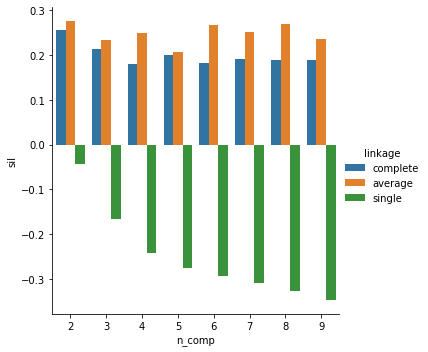

In [5]:
sns.catplot(x='n_comp',y='sil', hue= 'linkage',data=agg_model_all_df,kind='bar')

In [6]:
best_agg_model = AgglomerativeClustering(affinity = 'cosine', linkage = 'complete', 
                  n_clusters = 2).fit(X_all_cust_grp_scale_pca) 

X_zero = X_all_cust_grp_scale.iloc[best_agg_model.labels_==0]

X_one = X_all_cust_grp_scale.iloc[best_agg_model.labels_==1]

#X_two = X_all_cust_grp.iloc[best_agg_model.labels_==2]
#print(X_zero.describe().T)
#print(X_one.describe().T)

print(X_zero.shape[0])
print(X_one.shape[0])

A = (X_zero.describe().T/X_zero.shape[0] - X_one.describe().T/X_one.shape[0])*(X_zero.shape[0]+X_one.shape[0])

print(A.sort_values(by ='mean', ascending=False))

398
277
                                     count      mean       std       min  \
basket_size_L_sum                      0.0  2.931647  0.354484  1.006738   
nunique_products_mean                  0.0  2.428698  0.750761  1.212055   
n_products_mean                        0.0  2.306565  1.017130  1.122945   
sum_spend_mean                         0.0  2.209252  0.874994  1.293266   
std_quantity_mean                      0.0  2.003652  0.820726  0.883539   
basket_type_Top Up_sum                 0.0  1.950391  0.245323  0.989051   
basket_type_Full Shop_sum              0.0  1.564529  1.068305  0.453586   
basket_type_Full Shop_max              0.0  1.446171 -1.006003  0.896090   
basket_size_L_max                      0.0  1.387371 -2.727967  2.432925   
basket_dominant_mission_Mixed_sum      0.0  1.158891  0.333278  0.827872   
sum_spend_max                          0.0  1.035917  1.166539  0.758487   
shop_diff_mean                         0.0  0.693966  1.284252  0.321258   
shop

Text(0.5, 1.0, 'Mean Differences Between Groups (Scaled)')

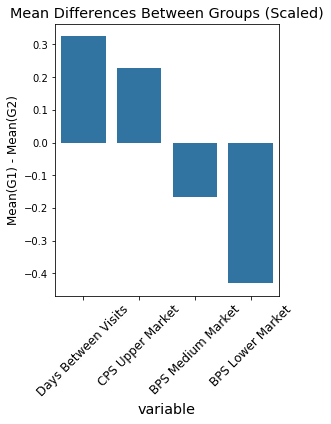

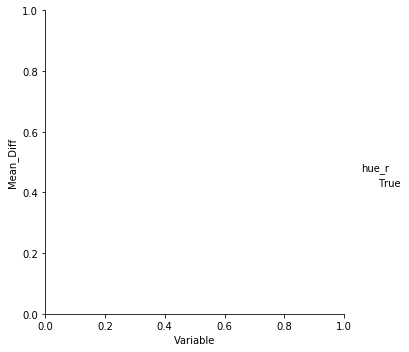

In [18]:
#Bar plot of above....
import scipy.stats as stats

results = [] ; 

test_index = ['shop_diff_mean',
              'cust_price_sensitivity_UM_max',
              'basket_price_sensitivity_MM_max',
            'basket_price_sensitivity_LA_max'       
            ]
for var in test_index:
    
    mean_diff = X_zero[var].mean() - X_one[var].mean()

    results.append([var,X_zero[var].mean(),X_one[var].mean(), mean_diff, stats.f_oneway(X_zero[var], X_one[var])[0],stats.f_oneway(X_zero[var], X_one[var])[1] ])

results_df = pd.DataFrame(results,columns = ['Variable','Group_1_mean','Group_2_mean','Mean_Diff','Fstat','P_value'])

#results_df = results_df.sort_values(by = 'Mean_Diff', ascending=False)

results_df['hue_r'] = results_df['Mean_Diff']<3

#plt.rcParams["figure.figsize"] = (8=20, 4)
fig_dims = (4, 5)
fig, ax = plt.subplots(figsize=fig_dims)
chart = sns.catplot(x='Variable',y='Mean_Diff',data=results_df,hue='hue_r',kind='bar', ax=ax)
ax.get_legend().remove()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_xticklabels(['Days Between Visits','CPS Upper Market','BPS Medium Market','BPS Lower Market'],fontsize='large')
ax.set_xlabel('variable',fontsize='x-large')
ax.set_ylabel('Mean(G1) - Mean(G2)',fontsize='large')
ax.set_title('Mean Differences Between Groups (Scaled)',fontsize='x-large')


In [8]:
results_df

,Variable,Group_1_mean,Group_2_mean,Mean_Diff,Fstat,P_value,hue_r
0,cust_price_sensitivity_LA_max,-0.083346,0.109348,0.192695,6.135700,0.013492,True
1,cust_price_sensitivity_MM_max,-0.014203,0.037389,0.051592,0.433190,0.510653,True
2,cust_price_sensitivity_UM_max,0.090383,-0.138644,-0.229027,8.676479,0.003335,True
3,shop_diff_mean,0.133525,-0.191852,-0.325377,17.693556,0.000029,True


In [9]:


X_all_cust_grp.head()


,std_quantity_mean,nunique_products_mean,n_products_mean,sum_spend_mean,sum_spend_max,cust_price_sensitivity_LA_max,cust_price_sensitivity_MM_max,cust_price_sensitivity_UM_max,basket_size_L_max,basket_size_L_sum,basket_size_L_count,basket_size_M_max,basket_size_M_sum,basket_size_S_max,basket_size_S_sum,basket_price_sensitivity_LA_max,basket_price_sensitivity_LA_sum,basket_price_sensitivity_MM_max,basket_price_sensitivity_MM_sum,basket_price_sensitivity_UM_max,basket_price_sensitivity_UM_sum,basket_type_Full Shop_max,basket_type_Full Shop_sum,basket_type_Small Shop_max,basket_type_Small Shop_sum,basket_type_Top Up_max,basket_type_Top Up_sum,basket_dominant_mission_Fresh_max,basket_dominant_mission_Fresh_sum,basket_dominant_mission_Grocery_max,basket_dominant_mission_Grocery_sum,basket_dominant_mission_Mixed_max,basket_dominant_mission_Mixed_sum,basket_dominant_mission_Nonfood_max,basket_dominant_mission_Nonfood_sum,shop_diff_min,shop_diff_max,shop_diff_mean
CUST0000570805,0.975847,10.793651,18.317460,20.592698,68.35,0,1,0,1,0.460317,63,1,0.269841,1,0.269841,1,0.079365,1,0.730159,1,0.190476,1,0.301587,1,0.539683,1,0.158730,1,0.380952,1,0.317460,1,0.253968,1,0.047619,0.0,75.0,12.548387
CUST0000571697,0.260586,3.775000,5.250000,7.256500,34.96,0,0,1,1,0.150000,40,1,0.325000,1,0.525000,1,0.100000,1,0.675000,1,0.225000,1,0.025000,1,0.700000,1,0.275000,1,0.375000,1,0.300000,1,0.250000,1,0.075000,0.0,477.0,20.794872
CUST0000571830,0.587450,7.527273,10.300000,13.216818,34.90,0,1,0,1,0.572727,110,1,0.309091,1,0.118182,1,0.436364,1,0.490909,1,0.072727,1,0.054545,1,0.336364,1,0.609091,1,0.718182,1,0.081818,1,0.163636,1,0.036364,0.0,30.0,7.486239
CUST0000572204,0.339935,11.500000,13.500000,26.060000,38.06,0,1,0,1,0.500000,2,1,0.500000,0,0.000000,0,0.000000,1,0.500000,1,0.500000,0,0.000000,0,0.000000,1,1.000000,1,0.500000,0,0.000000,1,0.500000,0,0.000000,330.0,330.0,330.000000
CUST0000572613,0.391119,4.730769,6.115385,8.205769,25.37,0,0,1,1,0.076923,26,1,0.730769,1,0.192308,1,0.038462,1,0.653846,1,0.307692,1,0.038462,1,0.538462,1,0.423077,1,0.423077,1,0.346154,1,0.230769,0,0.000000,0.0,73.0,16.840000


In [10]:

X_zero_p = X_all_cust_grp.iloc[best_agg_model.labels_==0]

X_one_p = X_all_cust_grp.iloc[best_agg_model.labels_==1]

print('Group_0 total spend',(X_zero_p['sum_spend_mean']*X_zero_p['basket_size_L_count']).sum())
print('Group_1 total spend',(X_one_p['sum_spend_mean']*X_one_p['basket_size_L_count']).sum())

Group_0 total spend 489648.79000000004
Group_1 total spend 151794.25


In [11]:
print(X_zero.shape[0])
print(X_one.shape[0])

398
277


In [12]:
results_df.head()


,Variable,Group_1_mean,Group_2_mean,Mean_Diff,Fstat,P_value,hue_r
0,cust_price_sensitivity_LA_max,-0.083346,0.109348,0.192695,6.135700,0.013492,True
1,cust_price_sensitivity_MM_max,-0.014203,0.037389,0.051592,0.433190,0.510653,True
2,cust_price_sensitivity_UM_max,0.090383,-0.138644,-0.229027,8.676479,0.003335,True
3,shop_diff_mean,0.133525,-0.191852,-0.325377,17.693556,0.000029,True


In [13]:
print(results_df['Variable'] == 'basket_type_Small Shop_sum')

0    False
1    False
2    False
3    False
Name: Variable, dtype: bool


In [14]:
results_df['Variable'] == ["basket_size_S_sum"]

ValueError: Lengths must match to compare

In [ ]:
hue_r